In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# profit ='/content/drive/MyDrive/1000_Companies.csv'
# cust_seg = '/content/drive/MyDrive/Customer_Segmentation.csv'
# revenue = '/content/drive/MyDrive/applerevenue.csv'
# price = '/content/drive/MyDrive/retail_price.csv'
# sales ='/content/drive/MyDrive/supermarket_sales.csv'

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pickle
import numpy as np
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

# Profit Prediction

In [8]:
#profit_data=pd.read_csv(profit)
profit_data = pd.read_csv('1000_companies.csv')
profit_data

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.800,471784.1000,New York,192261.83000
1,162597.70,151377.590,443898.5300,California,191792.06000
2,153441.51,101145.550,407934.5400,Florida,191050.39000
3,144372.41,118671.850,383199.6200,New York,182901.99000
4,142107.34,91391.770,366168.4200,Florida,166187.94000
...,...,...,...,...,...
995,54135.00,118451.999,173232.6695,California,95279.96251
996,134970.00,130390.080,329204.0228,California,164336.60550
997,100275.47,241926.310,227142.8200,California,413956.48000
998,128456.23,321652.140,281692.3200,California,333962.19000


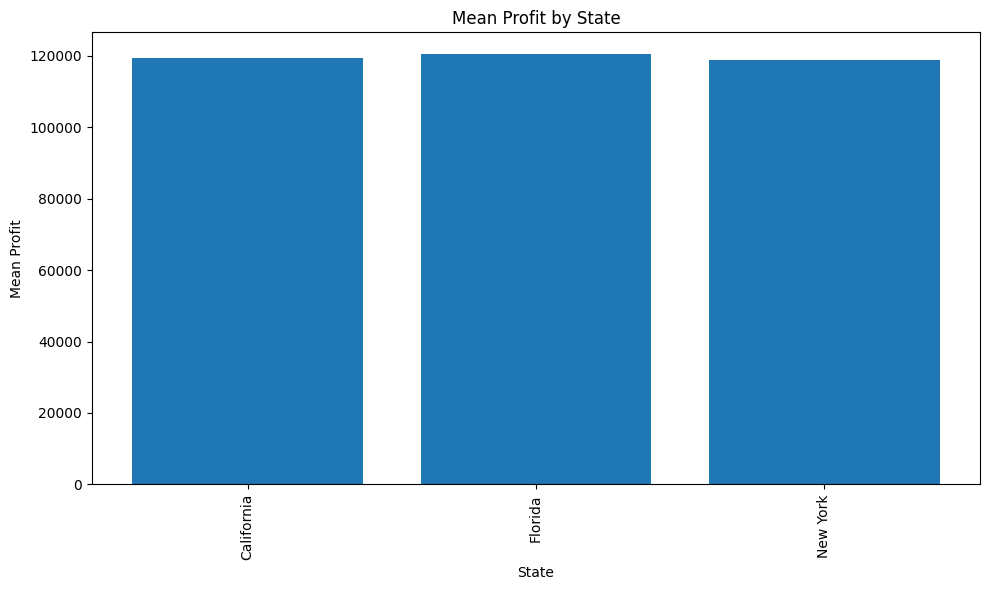

In [9]:
mean_profit_by_country = profit_data.groupby('State')['Profit'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(mean_profit_by_country['State'], mean_profit_by_country['Profit'])
plt.xlabel('State')
plt.ylabel('Mean Profit')
plt.title('Mean Profit by State')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_9200\2467160717.py:9: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


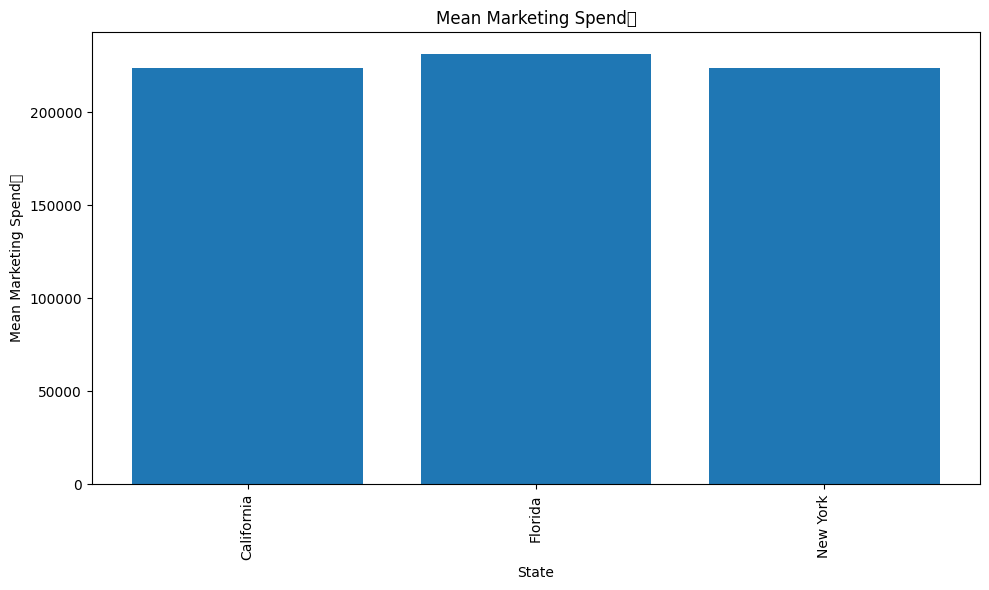

In [10]:
mean_profit_by_country = profit_data.groupby('State')['Marketing Spend'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(mean_profit_by_country['State'], mean_profit_by_country['Marketing Spend'])
plt.xlabel('State')
plt.ylabel('Mean Marketing Spend	')
plt.title('Mean Marketing Spend	')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

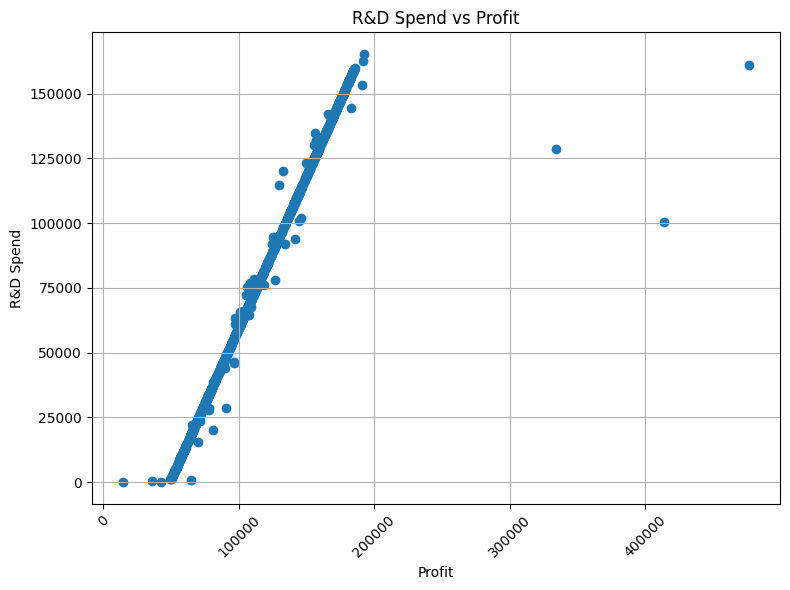

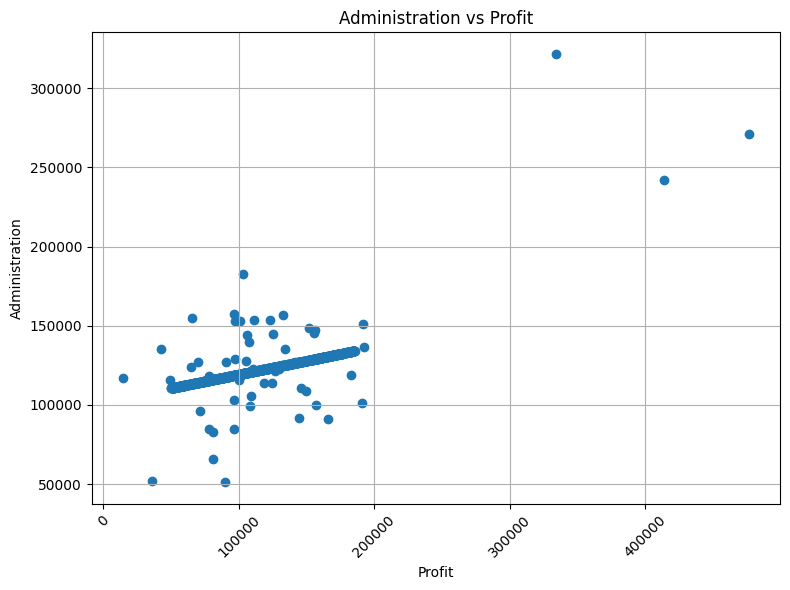

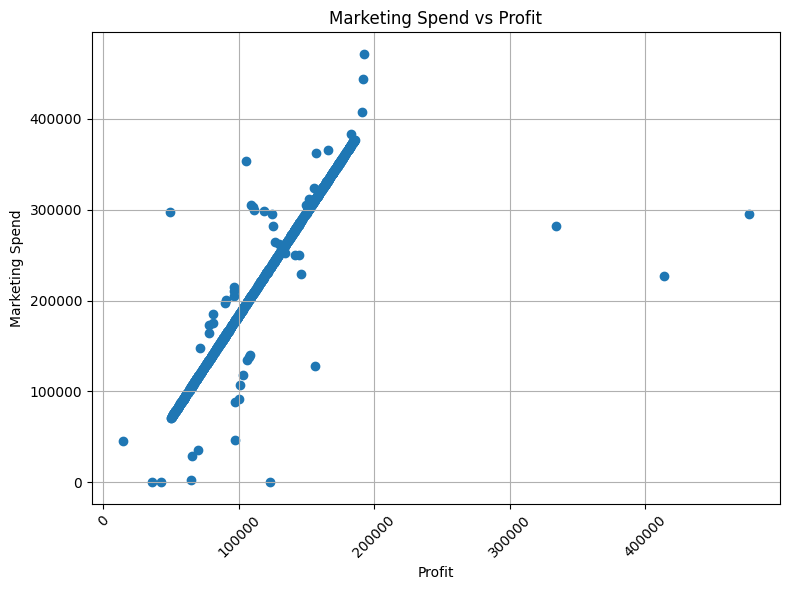

In [11]:
num_cols = ['R&D Spend', 'Administration', 'Marketing Spend']
for col in num_cols:
    plt.figure(figsize=(8, 6))
    plt.scatter(profit_data['Profit'], profit_data[col])
    plt.xlabel('Profit')
    plt.ylabel(col)
    plt.title(f'{col} vs Profit')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
profit_data.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

In [13]:
profit_data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


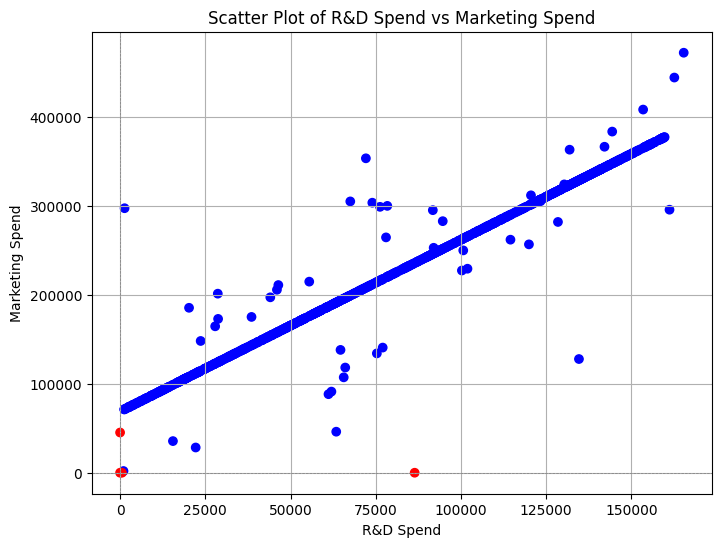

In [14]:
profit_data['Zero_R&D_Marketing'] = ((profit_data['R&D Spend'] == 0) | (profit_data['Marketing Spend'] == 0))

# Plotting
plt.figure(figsize=(8, 6))
colors = ['red' if is_zero else 'blue' for is_zero in profit_data['Zero_R&D_Marketing']]
plt.scatter(profit_data['R&D Spend'], profit_data['Marketing Spend'], color=colors)
plt.xlabel('R&D Spend')
plt.ylabel('Marketing Spend')
plt.title('Scatter Plot of R&D Spend vs Marketing Spend')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.grid(True)
plt.show()

In [15]:
y= profit_data['Profit']

In [16]:
X = profit_data.drop('Profit',axis=1)

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [18]:
numeric_features = ['R&D Spend', 'Administration', 'Marketing Spend']
categorical_features = ['State']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_new=preprocessor.fit_transform(X_train)
X_test1=preprocessor.transform(X_test)
clf = Pipeline(steps=[
                      ('rfe', RFE(estimator=LinearRegression(), n_features_to_select=1)),
                      ('classifier', LinearRegression())])
clf.fit(X_new,y_train)
y_pred = clf.predict(X_test1)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.2f}')

filename = 'profit_prediction.pkl'
pickle.dump(clf, open(filename, 'wb')) 


R-squared: 1.00


In [19]:
selected_features = preprocessor.transformers_[0][2] + list(clf.named_steps['rfe'].get_support(indices=True))
print('Selected Features:', selected_features)

Selected Features: ['R&D Spend', 'Administration', 'Marketing Spend', 0]


In [20]:
# the best feature is R&D Spend and it is giving r-squared as 1.00

In [24]:
lr = LinearRegression()
scaler = StandardScaler()

# Reshape the X_train['R&D Spend'] Series to a DataFrame
X_train_rd_spend = X_train[['R&D Spend']]

# Fit and transform the data
X_train_rd_spend_scaled = scaler.fit_transform(X_train_rd_spend)

# Transform the test data
X_test_rd_spend_scaled = scaler.transform(X_test[['R&D Spend']])

lr.fit(X_train_rd_spend_scaled,y_train)
y_pred = lr.predict(X_test_rd_spend_scaled )

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.2f}')

filename = 'profit_prediction.pkl'
pickle.dump(lr, open(filename, 'wb')) 

R-squared: 1.00
